# Inverse Hankel transform and the Ogata method

In [1]:
import numpy as np
import sympy as sp
import pylab as py
#from  matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text',usetex=True)
%matplotlib inline
import vegas
from scipy.special import jv, jn_zeros, yv
import scipy.special as spec
from scipy.optimize import fsolve
from scipy.optimize import fmin
from scipy.integrate import quad
from scipy.optimize import fsolve
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from inverters import AdOg
import warnings
#warnings.filterwarnings('ignore')

## gamma distribution function as prototype function in bT space

In [5]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import widgets, interactive
def f(x):
    return x
interact(f, x=10);

10

In [17]:
def Wtilde(bT,Q,sigma):
    M=1.0/Q
    V=1/sigma**2
    b=0.5*(-M+np.sqrt(M**2+4*V))
    a=V/b**2
    return bT**(a-1)*np.exp(-bT/b)/b**a/spec.gamma(a)

def W(qT, Q, sigma, nu):
    M=1.0/Q
    V=1/sigma**2
    b=0.5*(-M+np.sqrt(M**2+4*V))
    a=V/b**2
    return 1/(2*np.pi)*spec.gamma(a+nu)/spec.gamma(a)*(b*qT/2.0)**nu*spec.hyp2f1((a+nu)/2.0, (a+nu+1.0)/2.0, nu+1.0, -qT**2.0*b**2.0)/spec.gamma(nu+1.0)

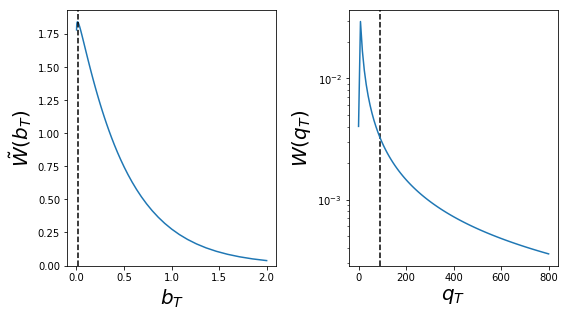

In [20]:
def update(Q=90,sigma=2,bTmax=10,qTmax=800,nu=1):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))

    ax=py.subplot(121)
    bT=10**np.linspace(-3,np.log10(bTmax),100)
    ax.plot(bT,Wtilde(bT,Q,sigma))
    ax.set_xlabel('$b_T$',size=20)
    ax.set_ylabel(r'$\tilde{W}(b_T)$',size=20)
    ax.axvline(1/Q,ls='--',color='k')
    ax.set_ylim(0,None)
    #ax.semilogx()

    
    
    ax=py.subplot(122)
    qT=np.linspace(1e-1,qTmax,100)    
    ax.axvline(Q,ls='--',color='k')
    ax.plot(qT,W(qT,Q,sigma,nu))
    ax.set_xlabel('$q_T$',size=20)
    ax.set_ylabel('$W(q_T)$',size=20)
    #ax.set_ylim(0,None)
    ax.semilogy()
    
    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),bTmax=(0,2),nu=(1,3,1),qTmax=(0,1000,1));

## numerical inversion using quadrature method

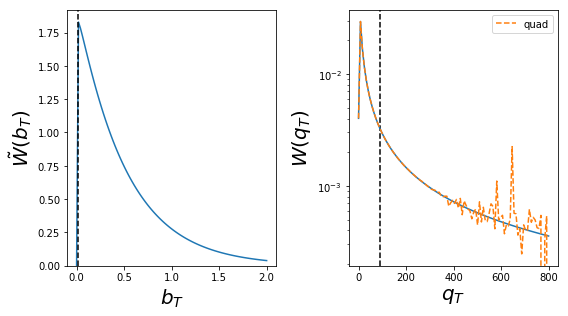

In [13]:
def Quadinversion1(w, q, nu):
    return 1/(2*np.pi)*quad(lambda bT: jv(nu,q*bT)*w(bT),0,np.inf)[0]

def update(Q=90,sigma=2,bTmax=10,qTmax=800,nu=1):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))

    ax=py.subplot(121)
    bT=np.linspace(0,bTmax,100)
    ax.plot(bT,Wtilde(bT,Q,sigma))
    ax.set_xlabel('$b_T$',size=20)
    ax.set_ylabel(r'$\tilde{W}(b_T)$',size=20)
    ax.axvline(1/Q,color='k',ls='--')
    ax.set_ylim(0,None)

    ax=py.subplot(122)    
    qT=np.linspace(1e-1,qTmax,100)    
    ax.axvline(Q,ls='--',color='k')
    ax.plot(qT,W(qT,Q,sigma,nu))
    ax.plot(qT,[Quadinversion1(lambda bT: Wtilde(bT,Q,sigma), q, nu) for q in qT],label='quad',ls='--')
    ax.legend()
    ax.set_xlabel('$q_T$',size=20)
    ax.set_ylabel('$W(q_T)$',size=20)
    ax.semilogy()

    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),bTmax=(0,2),nu=(1,3,1),qTmax=(0,1000,1));

## numerical inversion using MC method

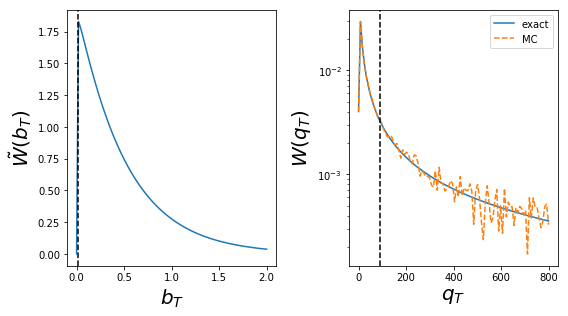

In [14]:
def transform(f, p):
    return f(np.tan(p))*(1/np.cos(p))**2
integ = vegas.Integrator([[0, np.pi/2.0]])

def MCinversion(f, q, nu, m):
    return 1/(2*np.pi)*float(str(integ(lambda p: transform(f, p)*jv(nu, q*np.tan(p)), nitn=10, neval=m)[0]).split('+-')[0].split('(')[0])

def update(Q=90,sigma=2,bTmax=10,qTmax=800,nu=1):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))

    ax=py.subplot(121)
    bT=np.linspace(0,bTmax,100)
    ax.plot(bT,Wtilde(bT,Q,sigma))
    ax.set_xlabel('$b_T$',size=20)
    ax.set_ylabel(r'$\tilde{W}(b_T)$',size=20)
    ax.axvline(1/Q,ls='--',color='k')


    ax=py.subplot(122)    
    qT=np.linspace(1e-1,qTmax,100)
    ax.plot(qT,W(qT,Q,sigma,nu),label='exact')
    ax.plot(qT,[MCinversion(lambda bT: Wtilde(bT,Q,sigma), q, nu, 400) for q in qT],label='MC',ls='--')
    ax.axvline(Q,ls='--',color='k')
    ax.legend()
    ax.set_xlabel('$q_T$',size=20)
    ax.set_ylabel('$W(q_T)$',size=20)
    ax.semilogy()


    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),bTmax=(0,2),nu=(1,3,1),qTmax=(0,1000,1));

# numerical inversion using Ogata method

## test the relation between x, xi, h and N

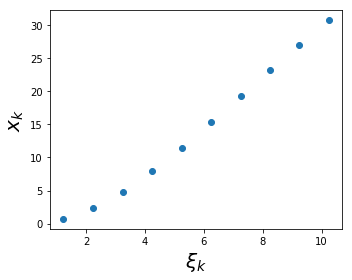

In [15]:
def update(h=0.1,N=10,nu=1):
    ncols,nrows=1,1
    fig = py.figure(figsize=(ncols*5,nrows*4))

    xnots=jn_zeros(nu,N)*np.tanh(np.pi/2*np.sinh(h/np.pi*jn_zeros(nu,N)))
    xi=jn_zeros(nu,N)/np.pi
        
    ax=py.subplot(111)
    ax.plot(xi,xnots,'o')
    ax.set_xlabel(r'$\xi_k$',size=20)
    ax.set_ylabel(r'$x_k$',size=20)

    py.tight_layout()    
    py.show()
interact(update,h=(0,10,0.01),N=(0,1000,1),nu=(1,3,1));

## test sampling region for a given qT

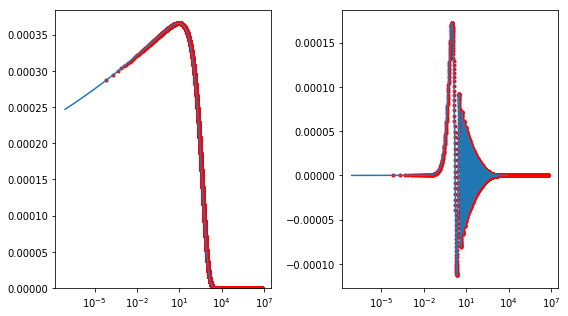

In [16]:
def update(Q=90,sigma=2,qT=800,nu=1):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))

    f=lambda x: 1/(2*np.pi*qT)*Wtilde(x/qT,Q,sigma)
    
    xmin=1e-10*qT
    xmax=10*qT
    zero1 = jn_zeros(nu, 1)[0]
    h = fsolve(lambda h: xmin-zero1/qT*np.tanh(np.pi/2*np.sinh(h/np.pi*zero1)), xmin)[0]
    k = fsolve(lambda k: xmax-np.pi*k/qT*np.tanh(np.pi/2*np.sinh(h*k)), xmax)[0]
    N = int(k)
    #print N
    #h=1
    #N=1000
    xnots=jn_zeros(nu,N)*np.tanh(np.pi/2*np.sinh(h/np.pi*jn_zeros(nu,N)))
    x=10**np.linspace(np.log10(xmin),np.log10(xmax),10000)
    
    ax=py.subplot(121)
    #ax.axvline(1/Q,color='k',ls='--')
    ax.plot(xnots,f(xnots),'r.')
    ax.plot(x,f(x))
    ax.set_ylim(0,None)
    ax.semilogx()

    ax=py.subplot(122)
    ax.plot(xnots,f(xnots)*jv(nu+1,np.pi*xnots),'r.')    
    ax.plot(x,f(x)*jv(nu+1,np.pi*x))

    #x=10**np.linspace(np.log10(xmin),np.log10(xmax),10000)
    #ax.set_ylim(0,None)
    ax.semilogx()

    
    #ax.semilogx()
    
    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),bTmax=(0,2),nu=(1,3,1),qT=(0,1000,1));

## implement ogata method

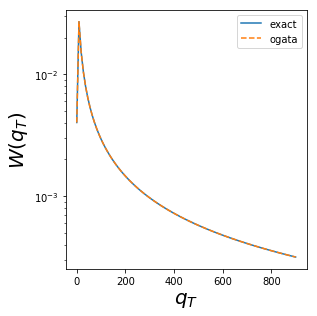

In [17]:
def ogata(f,h,N, nu):
    zeros=jn_zeros(nu,N)
    xi=zeros/np.pi
    Jp1=jv(nu+1,np.pi*xi)
    w=yv(nu, np.pi * xi) / Jp1
    get_psi=lambda t: t*np.tanh(np.pi/2*np.sinh(t))
    get_psip=lambda t:np.pi*t*(-np.tanh(np.pi*np.sinh(t)/2)**2 + 1)*np.cosh(t)/2 + np.tanh(np.pi*np.sinh(t)/2)
    knots=np.pi/h*get_psi(h*xi)
    Jnu=jv(nu,knots)
    psip=get_psip(h*xi)
    F=f(knots)
    return np.pi*np.sum(w*F*Jnu*psip)

def get_ogata_params(w, xmin, xmax, qT, nu):
    zero1 = jn_zeros(nu, 1)[0]
    h = fsolve(lambda h: xmin-zero1*np.tanh(np.pi/2*np.sinh(h/np.pi*zero1)), xmin)[0]
    k = fsolve(lambda k: xmax-np.pi*k*np.tanh(np.pi/2*np.sinh(h*k)), xmax)[0]
    N = int(k)
    return h,k,N

def Ogatainversion(w, xmin, xmax, qT, nu):
    h,k,N=get_ogata_params(w, xmin, xmax, qT, nu)
    return 1/(2*np.pi)*ogata(lambda x: w(x/qT)/qT,h,N, nu)

def update(Q=90,sigma=2,qTmax=900,nu=1):
    ncols,nrows=2,1
    fig = py.figure(figsize=(ncols*4,nrows*4.5))

    ax=py.subplot(121)
    qT=np.linspace(1e-1,qTmax,100)
    ax.plot(qT,W(qT,Q,sigma,nu),label='exact')
    xmin=lambda q: 1e-5*q#mean*q/500
    xmax=lambda q: 20*q#mean*q*100
    ax.plot(qT,[Ogatainversion(lambda bT: Wtilde(bT,Q,sigma),xmin(q),xmax(q),q,nu) for q in qT],label='ogata',ls='--')
    ax.legend()
    ax.set_xlabel('$q_T$',size=20)
    ax.set_ylabel('$W(q_T)$',size=20)
    ax.semilogy()

    py.tight_layout()    
    py.show()
interact(update,Q=(0,200,0.1),sigma=(0,10,0.01),nu=(1,3,1),qTmax=(0,1000,1));

In [18]:
def Quadinversion(w, q, nu, m):
    return 1/(2*np.pi)*quad(lambda bT: jv(nu,q*bT)*w(bT),0,np.inf, limit = m)[0]
import matplotlib.pyplot as plt
def Wtilde(bT, a, b):
    return bT**(a-1)*np.exp(-bT/b)/b**a/spec.gamma(a)
def W(q, a, b, nu):
    return 1/(2*np.pi)*spec.gamma(a+nu)/spec.gamma(a)*(b*q/2.0)**nu*spec.hyp2f1((a+nu)/2.0, (a+nu+1.0)/2.0, nu+1.0, -q**2.0*b**2.0)/spec.gamma(nu+1.0)

# Test at b = 100, restrict all inversion methods to 1e4 calls

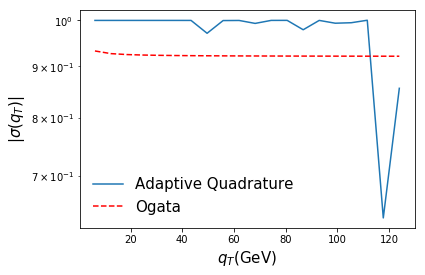

In [23]:
b = 10.0**(2.0)
Q = 124.0
a = 1.0+1.0/(b*Q)
cb = 10**(-4.2)
ct = 100.0
nu = 0.0
m = 10000
num = 20
f = np.vectorize(lambda bT: Wtilde(bT, a, b))
exact = lambda q: W(q, a, b, nu)
qlist = [float(Q/num*i) for i in range(1, num+1)]
#mclist = [abs(MCinversion(f, q, nu, m)/exact(q)) for q in qlist]
quadlist = [abs(Quadinversion(f, q, nu, m)/exact(q)) for q in qlist]
ogatalist = [abs(Ogatainversion(f, cb, ct, q, nu)/exact(q)) for q in qlist]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.subplot(111)
plt.yscale('log')
#plt.plot(qlist, mclist, label = 'Monte Carlo')
plt.plot(qlist, quadlist, label = 'Adaptive Quadrature')
plt.plot(qlist, ogatalist, 'r--', label = 'Ogata',)
plt.xlabel(r'$q_T$(GeV)', size = 15)
plt.ylabel(r'$|\sigma(q_T)|$', size = 15)
lgd = ax.legend(loc=3, prop={'size': 15}, frameon = False)
plt.show()
#fig.savefig('b2Q124.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [20]:
b = 10.0**(2.0)
Q = 124.0
a = 1.0+1.0/(b*Q)
cb = 10**(-4.2)
ct = 100.0
nu = 0.0
m = 10000
num = 20
f = np.vectorize(lambda bT: Wtilde(bT, a, b))
exact = lambda q: W(q, a, b, nu)

# Test at b = 0.1, restrict all inversion methods to 1e4 calls

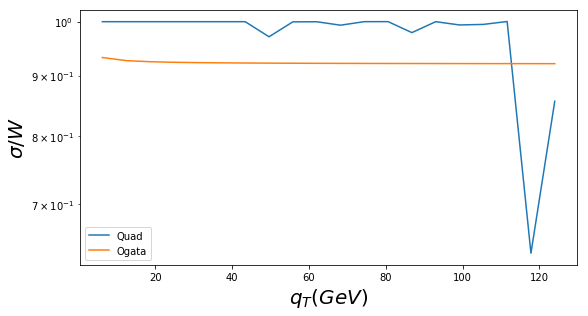

In [25]:
b = 10.0**(-1.0)
Q = 124.0
a = 1.0+1.0/(b*Q)
cb = 10**(-4.2)
ct = 100.0
nu = 0.0
m = 10000
num = 20
f = np.vectorize(lambda bT: Wtilde(bT, a, b))
exact = lambda qT: W(qT, a, b, nu)
qlist = [float(Q/num*i) for i in range(1, num+1)]
#mclist = [abs(MCinversion(f, q, nu, m)/exact(q)) for q in qlist]
#quadlist = [abs(Quadinversion(f, q, nu, m)/exact(q)) for q in qlist]
#ogatalist = [abs(Ogatainversion(f, cb, ct, q, nu)/exact(q)) for q in qlist]
ncols,nrows=2,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))
ax=py.subplot(111)
#ax.plot(qlist,mclist,label='MC')
ax.plot(qlist,quadlist,label='Quad')
ax.plot(qlist,ogatalist,label='Ogata')
#fig = plt.figure()
ax.legend(fontsize=10)
ax.set_ylabel(r'$\sigma/W$',size=20)
ax.set_xlabel(r'$q_T(GeV)$',size=20)

py.tight_layout()
ax.legend()
#py.semilogx()
py.semilogy()
py.show()
#plt.subplot(111)
#plt.yscale('log')
#plt.plot(qlist, mclist, label = 'Monte Carlo')
#plt.plot(qlist, quadlist, label = 'Adaptive Quadrature')
#plt.plot(qlist, ogatalist, 'r--', label = 'Ogata',)
#plt.xlabel(r'$q_T$(GeV)', size = 15)
#plt.ylabel(r'$|\sigma(q_T)|$', size = 15)
#lgd = ax.legend(loc=3, prop={'size': 15}, frameon = False)
#plt.show()
#fig.savefig('b2Q124.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Define Adaptive Sampling Algorithm (oversample and shorten)

In [55]:
def Ogatainversion(w, xmin, xmax, qT, nu):
    h,k,N=get_ogata_params(w, xmin, xmax, qT, nu)
    return 1/(2*np.pi)*ogata(lambda x: w(x/qT)/qT,h,N, nu), N

def AdaptOgataInversion(ftilde, f, iterations, threshold, xmax, xmin, m, qT):
    exact = f(qT)
    try:
        for i in range(iterations):
            bool1 = abs(exact-Ogatainversion(ftilde, xmin, xmax*np.log(1+1/m), qT, nu)[0])<threshold
            bool2 = abs(exact-Ogatainversion(ftilde, xmin/np.log(1+1/m), xmax, qT, nu)[0])<threshold
            boollist = [bool1, bool2]
            if boollist == [True, True]:
                if abs(exact-Ogatainversion(ftilde, xmin, xmax*np.log(1+1/m), qT, nu)[0])>abs(exact-Ogatainversion(ftilde, xmin/np.log(1+1/m), xmax, qT, nu)[0]):
                    return AdaptOgataInversion(ftilde, f, iterations-1, threshold, xmax, xmin/np.log(1+1/m), m, qT)
                else:
                    return AdaptOgataInversion(ftilde, f, iterations-1, threshold, xmax*np.log(1+1/m), xmin, m, qT)
            if boollist == [False, True]:
                return AdaptOgataInversion(ftilde, f, iterations-1, threshold, xmax, xmin/np.log(1+1/m), m, qT)
            if boollist == [True, False]:
                return AdaptOgataInversion(ftilde, f, iterations-1, threshold, xmax*np.log(1+1/m), xmin, m, qT)
            else:
                return AdaptOgataInversion(ftilde, f, iterations-1, threshold, xmax, xmin, m+1, qT)
        return xmin, xmax, Ogatainversion(ftilde, xmin, xmax, qT, nu)[1]
    except:
        return xmin, xmax, Ogatainversion(ftilde, xmin, xmax, qT, nu)[1]
    
def Wtilde(bT,Q,sigma):
    M=1.0/Q
    V=1/sigma**2
    b=0.5*(-M+np.sqrt(M**2+4*V))
    a=V/b**2
    return bT**(a-1)*np.exp(-bT/b)/b**a/spec.gamma(a)

def W(qT, Q, sigma, nu):
    M=1.0/Q
    V=1/sigma**2
    b=0.5*(-M+np.sqrt(M**2+4*V))
    a=V/b**2
    return 1/(2*np.pi)*spec.gamma(a+nu)/spec.gamma(a)*(b*qT/2.0)**nu*spec.hyp2f1((a+nu)/2.0, (a+nu+1.0)/2.0, nu+1.0, -qT**2.0*b**2.0)/spec.gamma(nu+1.0)


# Number optimization

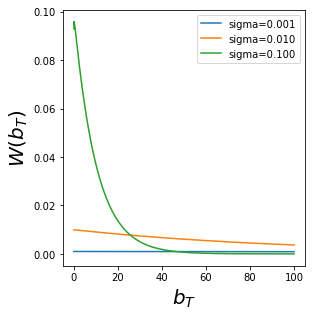

In [56]:
Q = np.sqrt(124.0)
bT=10**np.linspace(-3,np.log10(100),1000)
FFtilde={}
for sigma in [0.001,0.01 ,0.1]:
    FFtilde[sigma]=[Wtilde(_bT,Q,sigma) for _bT in bT]
ncols,nrows=2,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))
ax=py.subplot(121)
for sigma in [1e-3,1e-2,1e-1]:
    ax.plot(bT,FFtilde[sigma],label='sigma=%0.3f'%(sigma))
ax.legend(fontsize=10)
ax.set_ylabel(r'$W(b_T)$',size=20)
ax.set_xlabel(r'$b_T$',size=20)

#ax=py.subplot(122)
#for sigma in [0.001,0.01 ,0.1]:
#    ax.plot(bT,FFtilde[sigma],label='sigma=%0.3f'%(sigma))
#ax.legend(fontsize=10)
#ax.set_ylabel(r'$W(b_T)$',size=20)
#ax.set_xlabel(r'$b_T$',size=20)
#py.semilogx();

py.tight_layout()

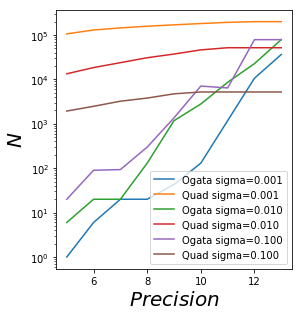

In [46]:
Q = np.sqrt(124.0)
nu = 0.0
xmin = 1e-5
xmax = 1e5
iterations = 200
m = 1.0
ftilde = lambda bT: Wtilde(bT, Q, sigma)
f = lambda q: W(q, Q, sigma, nu)
qT = Q/2
threshold = [10.0**(-i) for i in range(5, 14)]

QuadN = {}
OgataN = {}
for sigma in [1e-3,1e-2 ,1e-1]:
    OgataN[sigma]=[AdaptOgataInversion(ftilde, f, iterations, tau, xmax, xmin, m, qT)[2] for tau in threshold]
    QuadN[sigma] = [quad(lambda bT: jv(nu,qT*bT)*ftilde(bT),0,np.inf, epsabs = tau, full_output = 1, limit = 100000)[2]['neval'] for tau in threshold]
    
preclist = [np.log10(1/tau) for tau in threshold]

ncols,nrows=2,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))
ax=py.subplot(121)
for sigma in [1e-3,1e-2 ,1e-1]:
    ax.plot(preclist,OgataN[sigma],label='Ogata sigma=%0.3f'%(sigma))
    ax.plot(preclist,QuadN[sigma],label='Quad sigma=%0.3f'%(sigma))
ax.legend(fontsize=10)
ax.set_ylabel(r'$N$',size=20)
ax.set_xlabel(r'$Precision$',size=20)

py.tight_layout()
ax.legend()
#py.semilogx()
py.semilogy()
py.show()

#py.tight_layout()    
#fig.savefig('toy_rate_of_convergence.pdf')

# Inversion of a real TMD FF (using Kangs Fotran codes)

### ATENTTION:  

- iqq argument in tmdff.fftilde differs from the array index of tmdff.tmdff.
- iqq: 1(u),-1(ub), 2(d),-2(db),3(s),-3(sb),0(g)
- tmdff.tmdff array: [u,ub,d,db,s,sb,g]

## load fortran library and initialize parameters

In [4]:
from lib.tmdff import tmdff
root='../lib/tmdff/'
tmdff.root.root=root.ljust(255)
tmdff.meson.ih=1
tmdff.meson.ic=1
tmdff.meson.fini=0

## plot TMD FF(u) in qT space from the fortran code

In [5]:
z=0.4
pT=np.linspace(0,2,50)
FF={}
for Q2 in [2.4,10,1000]:
    FF[Q2]=[tmdff.tmdff(z,_pT,Q2**0.5)[0] for _pT in pT]

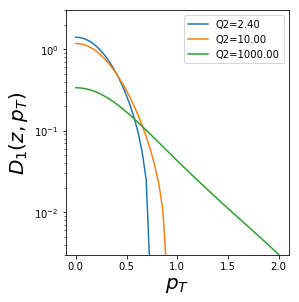

In [6]:
ncols,nrows=1,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))
ax=py.subplot(111)
for Q2 in [2.4,10,1000]:
    ax.plot(pT,FF[Q2],label='Q2=%0.2f'%(Q2))
ax.set_ylim(3e-3,3)
ax.set_ylabel(r'$D_1(z,p_T)$',size=20)
ax.set_xlabel(r'$p_T$',size=20)
ax.legend(fontsize=10)
py.semilogy(nonposy='clip');

## Plot TMD FF (u) in bT from the fortran code

In [28]:
z=0.4
bT=10**np.linspace(-3,np.log10(10),1000)
FFtilde={}
for Q2 in [2.4,10,1000]:
    FFtilde[Q2]=[tmdff.fftilde(_bT,z,Q2**0.5,1) for _bT in bT]

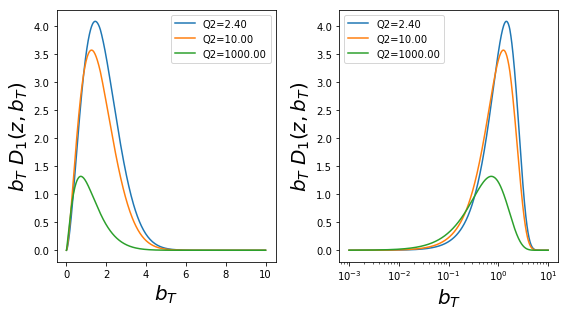

In [29]:
ncols,nrows=2,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))
ax=py.subplot(121)
for Q2 in [2.4,10,1000]:
    ax.plot(bT,FFtilde[Q2],label='Q2=%0.2f'%(Q2))
ax.legend(fontsize=10)
ax.set_ylabel(r'$b_T\;D_1(z,b_T)$',size=20)
ax.set_xlabel(r'$b_T$',size=20)

ax=py.subplot(122)
for Q2 in [2.4,10,1000]:
    ax.plot(bT,FFtilde[Q2],label='Q2=%0.2f'%(Q2))
ax.legend(fontsize=10)
ax.set_ylabel(r'$b_T\;D_1(z,b_T)$',size=20)
ax.set_xlabel(r'$b_T$',size=20)
py.semilogx();

py.tight_layout()


## use ogata method for inversion

In [35]:
def ogata(f,h,N, nu):
    zeros=jn_zeros(nu,N)
    xi=zeros/np.pi
    Jp1=jv(nu+1,np.pi*xi)
    w=yv(nu, np.pi * xi) / Jp1
    get_psi=lambda t: t*np.tanh(np.pi/2*np.sinh(t))
    get_psip=lambda t:np.pi*t*(-np.tanh(np.pi*np.sinh(t)/2)**2 + 1)*np.cosh(t)/2 + np.tanh(np.pi*np.sinh(t)/2)
    knots=np.pi/h*get_psi(h*xi)
    Jnu=jv(nu,knots)
    psip=get_psip(h*xi)
    F=f(knots)
    return np.pi*np.sum(w*F*Jnu*psip)

def get_ogata_params(w, xmin, xmax, qT, nu):
    zero1 = jn_zeros(nu, 1)[0]
    h = fsolve(lambda h: xmin-zero1*np.tanh(np.pi/2*np.sinh(h/np.pi*zero1)), xmin)[0]
    k = fsolve(lambda k: xmax-np.pi*k*np.tanh(np.pi/2*np.sinh(h*k)), xmax)[0]
    N = int(k)
    return h,k,N

def Ogatainversion(w, xmin, xmax, qT, nu):
    h,k,N=get_ogata_params(w, xmin, xmax, qT, nu)
    return 1/(2*np.pi)*ogata(lambda x: w(x/qT)/qT,h,N, nu)



### set kinematics

In [36]:
nu=0
z=0.4
pT=np.linspace(1e-2,2,100)
xmin=lambda pT: 1e-3*pT/z
xmax=lambda pT: 10*pT/z

In [37]:
%%time
FFogata={}
for Q2 in [2.4,10,1000]:
    Wtilde=np.vectorize(lambda bT:tmdff.fftilde(bT,z,Q2**0.5,1))
    FFogata[Q2]=np.array([Ogatainversion(Wtilde,xmin(_pT),xmax(_pT),_pT/z,nu) for _pT in pT])

CPU times: user 10.7 s, sys: 32 ms, total: 10.7 s
Wall time: 10.6 s


In [60]:
%%time
FFQuad={}
for Q2 in [2.4,10,1000]:
    Wtilde=np.vectorize(lambda bT:tmdff.fftilde(bT,z,Q2**0.5,1))
    FFogata[Q2]=np.array([Quadinversion1(Wtilde,_pT/z,nu) for _pT in pT])

CPU times: user 45 s, sys: 872 ms, total: 45.8 s
Wall time: 44.6 s


In [38]:
%%time
FF={}
for Q2 in [2.4,10,1000]:
    FF[Q2]=[tmdff.tmdff(z,_pT,Q2**0.5)[0] for _pT in pT]

CPU times: user 43.4 s, sys: 44 ms, total: 43.4 s
Wall time: 43.5 s


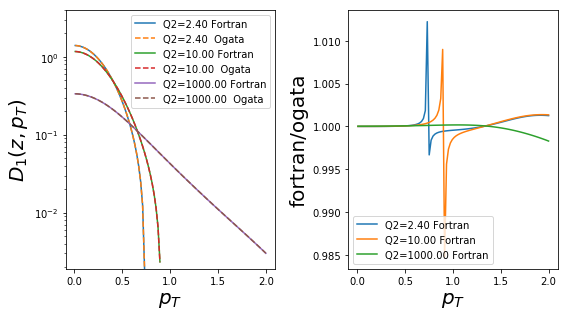

In [39]:
ncols,nrows=2,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))

ax=py.subplot(121)
for Q2 in [2.4,10,1000]:
    ax.plot(pT,FF[Q2],label='Q2=%0.2f Fortran'%(Q2))
    ax.plot(pT,FFogata[Q2],ls='--',label='Q2=%0.2f  Ogata'%(Q2))
ax.legend()
ax.semilogy()
ax.set_ylim(0,4)
py.tight_layout()    
ax.set_ylabel(r'$D_1(z,p_T)$',size=20)
ax.set_xlabel(r'$p_T$',size=20)

ax=py.subplot(122)
for Q2 in [2.4,10,1000]:
    ax.plot(pT,FF[Q2]/FFogata[Q2],label='Q2=%0.2f Fortran'%(Q2))
ax.legend()
ax.set_xlabel('$p_T$',size=20)
ax.set_ylabel('fortran/ogata',size=20)
py.tight_layout()    
py.savefig('D1.pdf')



## Ok Fortran and Ogata maches!!! Lets check next the high pT region

In [51]:
nu=0
z=0.4
Q2=100000
pT=np.linspace(1e-2,20,100)
xmin=lambda pT: 1e-3*pT/z
xmax=lambda pT: 10*pT/z

Wtilde=np.vectorize(lambda bT:tmdff.fftilde(bT,z,Q2**0.5,1))
FFogata=np.array([Ogatainversion(Wtilde,xmin(_pT),xmax(_pT),_pT/z,nu) for _pT in pT])
FF=[tmdff.tmdff(z,_pT,Q2**0.5)[0] for _pT in pT]

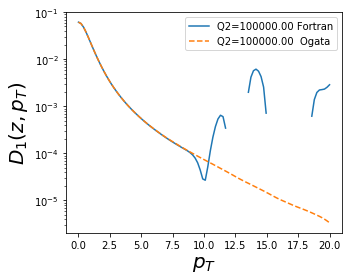

In [52]:
ncols,nrows=1,1
fig = py.figure(figsize=(ncols*5,nrows*4))

ax=py.subplot(111)
ax.plot(pT,FF,label='Q2=%0.2f Fortran'%(Q2))
ax.plot(pT,FFogata,ls='--',label='Q2=%0.2f  Ogata'%(Q2))
ax.legend()
ax.semilogy()
#ax.set_ylim(0,4)
py.tight_layout()    
ax.set_ylabel(r'$D_1(z,p_T)$',size=20)
ax.set_xlabel(r'$p_T$',size=20)
py.tight_layout()    
py.savefig('D1-HighPT.pdf')


# Let's check the quad inversion

In [55]:
nu=0
z=0.4
Q2=100000
pT=np.linspace(1e-2,20,100)
xmin=lambda pT: 1e-3*pT/z
xmax=lambda pT: 10*pT/z

Wtilde=np.vectorize(lambda bT:tmdff.fftilde(bT,z,Q2**0.5,1))
FFogata=np.array([Ogatainversion(Wtilde,xmin(_pT),xmax(_pT),_pT/z,nu) for _pT in pT])
FFquad=np.array([Quadinversion1(Wtilde,_pT/z,nu) for _pT in pT])
FF=[tmdff.tmdff(z,_pT,Q2**0.5)[0] for _pT in pT]

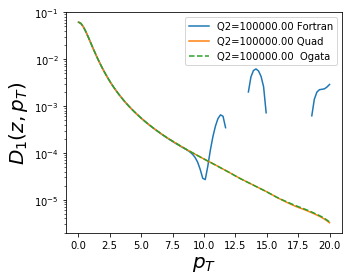

In [56]:
ncols,nrows=1,1
fig = py.figure(figsize=(ncols*5,nrows*4))

ax=py.subplot(111)
ax.plot(pT,FF,label='Q2=%0.2f Fortran'%(Q2))
ax.plot(pT,FFquad,label='Q2=%0.2f Quad'%(Q2))
ax.plot(pT,FFogata,ls='--',label='Q2=%0.2f  Ogata'%(Q2))
ax.legend()
ax.semilogy()
#ax.set_ylim(0,4)
py.tight_layout()    
ax.set_ylabel(r'$D_1(z,p_T)$',size=20)
ax.set_xlabel(r'$p_T$',size=20)
py.tight_layout()    
#py.savefig('D1-HighPT.pdf')


# Need slower decaying function. Try for different values of z

In [58]:
Q2 =10000.0
bT=10**np.linspace(-3,np.log10(10),1000)
FFtilde={}
for z in [0.1,0.5,0.9]:
    FFtilde[z]=[tmdff.fftilde(_bT,z,Q2**0.5,1) for _bT in bT]

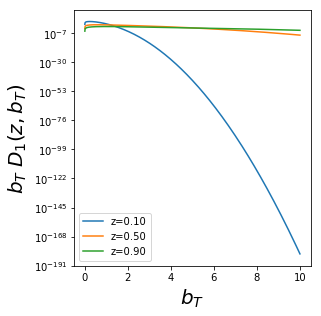

In [60]:
ncols,nrows=2,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))
ax=py.subplot(121)
for z in [0.1,0.5,0.9]:
    ax.plot(bT,FFtilde[z],label='z=%0.2f'%(z))
ax.legend(fontsize=10)
ax.set_ylabel(r'$b_T\;D_1(z,b_T)$',size=20)
ax.set_xlabel(r'$b_T$',size=20)
ax.semilogy()

py.tight_layout()

# Check for high z

In [58]:
nu=0
z=0.99
Q2=100000
pT=np.linspace(1e-2,7,100)
xmin=lambda pT: 1e-3*pT/z
xmax=lambda pT: 10*pT/z

Wtilde=np.vectorize(lambda bT:tmdff.fftilde(bT,z,Q2**0.5,1))
FFogata=np.array([Ogatainversion(Wtilde,xmin(_pT),xmax(_pT),_pT/z,nu)[0] for _pT in pT])
#FFquad=np.array([1/(2*np.pi)*quad(lambda bT: jv(nu,q*_pT)*Wtilde(bT),0,np.inf, epsrel = 1e-5)[0] for _pT in pT])
FFquad=np.array([Quadinversion1(Wtilde,_pT/z,nu) for _pT in pT])
FF=[tmdff.tmdff(z,_pT,Q2**0.5)[0] for _pT in pT]

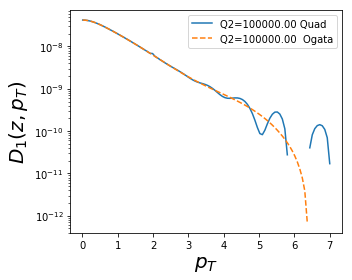

In [59]:
ncols,nrows=1,1
fig = py.figure(figsize=(ncols*5,nrows*4))

ax=py.subplot(111)
#ax.plot(pT,FF,label='Q2=%0.2f Fortran'%(Q2))
ax.plot(pT,FFquad,label='Q2=%0.2f Quad'%(Q2))
ax.plot(pT,FFogata,ls='--',label='Q2=%0.2f  Ogata'%(Q2))
ax.legend()
ax.semilogy()
#ax.set_ylim(0,4)
py.tight_layout()    
ax.set_ylabel(r'$D_1(z,p_T)$',size=20)
ax.set_xlabel(r'$p_T$',size=20)
py.tight_layout()    
#py.savefig('D1-HighPT.pdf')

# Check Sampling number for this region(A slow but effective algorithm)

In [89]:
def find_bmax(f, bmin, bmax, bnum = 20):
    bT = np.exp(np.linspace(np.log(bmin), np.log(bmax), bnum))
    f_bT = [f(b) for b in bT]
    imax = [i for i, j in enumerate(f_bT) if j == max(f_bT)][0]
    b_list_max = bT[imax]
    bmax = fmin(lambda x: -f(x), b_list_max, disp = False)
    return bmax[0]
def get_ogata_params_ad(w, bmin, bmax, qT, nu):
    zero1 = jn_zeros(nu, 1)[0]
    h = fsolve(lambda h: bmin-zero1/qT*np.tanh(np.pi/2*np.sinh(h/np.pi*zero1)), bmin)[0]
    k = fsolve(lambda k: bmax-np.pi/qT*k*np.tanh(np.pi/2*np.sinh(h*k)), bmax)[0]
    N = int(k)
    return h,N
def compare(w, ib, it, bc, qT, nu):
    h1,N1=get_ogata_params_ad(w, bc/((2)**ib), bc*2**it, qT, nu)
    h2,N2=get_ogata_params_ad(w, bc/((2)**(ib+1)), bc*2**(it+1), qT, nu)
    val1 = ogata(lambda x: w(x/qT)/qT,h1,N1, nu)
    val2 = ogata(lambda x: w(x/qT)/qT,h1,N2, nu)
    val3 = ogata(lambda x: w(x/qT)/qT,h2,N1, nu)
    val4 = ogata(lambda x: w(x/qT)/qT,h2,N2, nu)
    return [abs((val1-val4)/val4)<tau, abs((val2-val4)/val4)<abs((val3-val4)/val4)], h1, N1, h2, N2
def CutOgataInversion(ftilde, iterations, threshold, h, N, m, qT):
    exact = ogata(lambda x: ftilde(x/qT)/qT,h,N, nu)
    cut_up = ogata(lambda x: ftilde(x/qT)/qT, h, int(N*np.log(1+1/m)), nu)
    cut_down = ogata(lambda x: ftilde(x/qT)/qT, h/np.log(1+1/m), N, nu)
    try:
        for i in range(iterations):
            bool1 = abs((exact-cut_up)/exact)<threshold
            bool2 = abs((exact-cut_down)/exact)<threshold
            boollist = [bool1, bool2]
            if boollist == [True, True]:
                if abs(exact-cut_up)>abs(exact-cut_down):
                    return CutOgataInversion(ftilde, iterations-1, threshold, h/np.log(1+1/m), N, m, qT)
                else:
                    return CutOgataInversion(ftilde, iterations-1, threshold, h, int(N*np.log(1+1/m)), m, qT)
            if boollist == [False, True]:
                return CutOgataInversion(ftilde, iterations-1, threshold, h/np.log(1+1/m), N, m, qT)
            if boollist == [True, False]:
                return CutOgataInversion(ftilde, iterations-1, threshold, h, int(N*np.log(1+1/m)), m, qT)
            else:
                return CutOgataInversion(ftilde, iterations-1, threshold, h, N, m+1, qT)
        return 1/(2*np.pi)*exact, h, N
    except:
        return 1/(2*np.pi)*exact, h, N
def AdaptOgatainversion(w, qT, nu, tau, imax, ib = 1, it = 1, bpeak = [], shorten = False):
    short = shorten
    if ib+it< imax:
        if not bpeak:
            bc = find_bmax(w, 1e-2, 1e1)
        else:
            bc = bpeak[0]
        boollist, h1, N1, h2, N2 = compare(w, ib, it, bc, qT, nu)
        if boollist[0] == False:
            if boollist[1] == True:
                return AdaptOgatainversion(w, qT, nu, tau, imax, ib = ib+0, it = it+1, bpeak = [bc], shorten = short)
            else:
                return AdaptOgatainversion(w, qT, nu, tau, imax, ib = ib+1, it = it+0, bpeak = [bc], shorten = short)
        else:
            if short == True:
                m = 1.0
                return CutOgataInversion(w, imax, tau, h1, N1, m, qT)
            else:
                return 1/(2*np.pi)*ogata(lambda x: w(x/qT)/qT,h1,N1, nu), h1, N1
    else:
        print('imax reached')

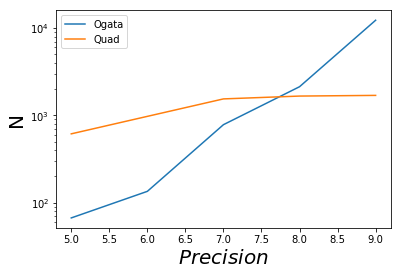

In [91]:
nu=0
z=0.4
Q2=100000.0
qT = 1.0
imax = 100

Wtilde=np.vectorize(lambda bT:tmdff.fftilde(bT,z,Q2**0.5,1))
threshold = [10.0**(-i) for i in range(5, 10)]
ogatalist = [AdaptOgatainversion(Wtilde, qT/z, nu, tau, imax, ib = 1, it = 1, shorten = True)[2] for tau in threshold]
quadlist = [quad(lambda bT: jv(nu,qT*bT)*Wtilde(bT),0,np.inf, epsabs = tau, full_output = 1, limit = 100000)[2]['neval'] for tau in threshold]
preclist = [np.log10(1/tau) for tau in threshold]
ax=py.subplot(111)
ax.plot(preclist, ogatalist, label = 'Ogata')
ax.plot(preclist, quadlist, label = 'Quad')
ax.set_xlabel('$Precision$',size=20)
ax.set_ylabel('N',size=20)
ax.legend()
#py.semilogx()
py.semilogy()
py.show()

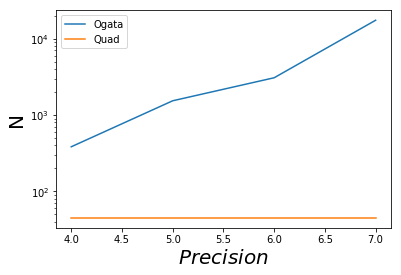

In [103]:
nu=0
z=0.99
Q2=100000.0
qT = 5.0
imax = 100

Wtilde=np.vectorize(lambda bT:tmdff.fftilde(bT,z,Q2**0.5,1))
threshold = [10.0**(-i) for i in range(4, 8)]
ogatalist = [AdaptOgatainversion(Wtilde, qT/z, nu, tau, imax, ib = 1, it = 1, shorten = True)[2] for tau in threshold]
quadlist = [quad(lambda bT: jv(nu,qT*bT)*Wtilde(bT),0,np.inf, epsabs = tau, full_output = 1, limit = 100000)[2]['neval'] for tau in threshold]
preclist = [np.log10(1/tau) for tau in threshold]
ax=py.subplot(111)
ax.plot(preclist, ogatalist, label = 'Ogata')
ax.plot(preclist, quadlist, label = 'Quad')
ax.set_xlabel('$Precision$',size=20)
ax.set_ylabel('N',size=20)
ax.legend()
#py.semilogx()
py.semilogy()
py.show()

In [7]:
from lib.jettmdff import jettmdff
root='../lib/jettmdff/'
jettmdff.root.root=root.ljust(255)
jettmdff.meson.ih=1
jettmdff.meson.ic=1
jettmdff.meson.fini=0

In [8]:
z=0.4
pT=np.linspace(0,2,50)
FF={}
for Q2 in [2.4,10,1000]:
    FF[Q2]=[jettmdff.tmdff(z,_pT,Q2**0.5)[0] for _pT in pT]

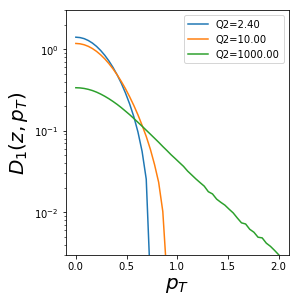

In [9]:
ncols,nrows=1,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))
ax=py.subplot(111)
for Q2 in [2.4,10,1000]:
    ax.plot(pT,FF[Q2],label='Q2=%0.2f'%(Q2))
ax.set_ylim(3e-3,3)
ax.set_ylabel(r'$D_1(z,p_T)$',size=20)
ax.set_xlabel(r'$p_T$',size=20)
ax.legend(fontsize=10)
py.semilogy(nonposy='clip');

In [107]:
z=0.4
bT=10**np.linspace(-3,np.log10(10),1000)
FFtilde={}
for Q2 in [2.4,10,1000]:
    FFtilde[Q2]=[jettmdff.fftilde(_bT,z,Q2**0.5,1) for _bT in bT]

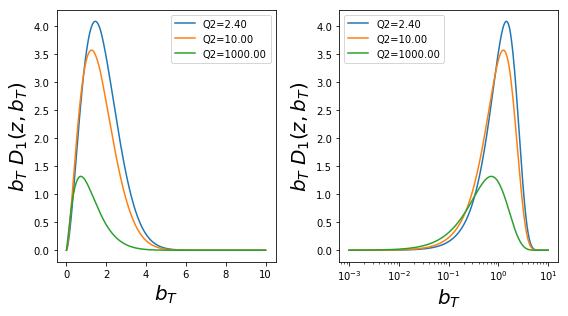

In [108]:
ncols,nrows=2,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))
ax=py.subplot(121)
for Q2 in [2.4,10,1000]:
    ax.plot(bT,FFtilde[Q2],label='Q2=%0.2f'%(Q2))
ax.legend(fontsize=10)
ax.set_ylabel(r'$b_T\;D_1(z,b_T)$',size=20)
ax.set_xlabel(r'$b_T$',size=20)

ax=py.subplot(122)
for Q2 in [2.4,10,1000]:
    ax.plot(bT,FFtilde[Q2],label='Q2=%0.2f'%(Q2))
ax.legend(fontsize=10)
ax.set_ylabel(r'$b_T\;D_1(z,b_T)$',size=20)
ax.set_xlabel(r'$b_T$',size=20)
py.semilogx();

py.tight_layout()

In [109]:
def Quadinversioneps(w, q, nu, eps):
    lst = quad(lambda bT: jv(nu,q*bT)*w(bT),0,np.inf, epsabs = eps, full_output = 1)
    return 1/(2*np.pi)*lst[0], lst[1]

In [137]:
nu=0
z=0.4
pT=np.linspace(1e-2,5,100)
tau = 0.05
imax = 100

In [138]:
%%time
FFogata={}
for Q2 in [2.4,10,1000]:
    Wtilde=np.vectorize(lambda bT:jettmdff.fftilde(bT,z,Q2**0.5,1))
    FFogata[Q2]=np.array([AdaptOgatainversion(Wtilde, _pT/z, nu, tau, imax, ib = 1, it = 1, bpeak = [], shorten = False)[0] for _pT in pT])

CPU times: user 34.3 s, sys: 20 ms, total: 34.3 s
Wall time: 34.3 s


In [ ]:
%%time
FFquad={}
for Q2 in [2.4,10,1000]:
    Wtilde=np.vectorize(lambda bT:jettmdff.fftilde(bT,z,Q2**0.5,1))
    FFquad[Q2]=np.array([Quadinversioneps(Wtilde, _pT/z, nu, tau)[0] for _pT in pT])

CPU times: user 9.67 s, sys: 40 ms, total: 9.71 s
Wall time: 9.69 s


In [ ]:
%%time
FF={}
for Q2 in [2.4,10,1000]:
    FF[Q2]=[jettmdff.tmdff(z,_pT,Q2**0.5)[0] for _pT in pT]

In [ ]:
ncols,nrows=2,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))

ax=py.subplot(121)
for Q2 in [2.4,10,1000]:
    ax.plot(pT,FFquad[Q2],label='Q2=%0.2f quad'%(Q2))
    ax.plot(pT,FFogata[Q2],ls='--',label='Q2=%0.2f  Ogata'%(Q2))
ax.legend()
ax.semilogy()
ax.set_ylim(0,4)
py.tight_layout()    
ax.set_ylabel(r'$D_1(z,p_T)$',size=20)
ax.set_xlabel(r'$p_T$',size=20)

ax=py.subplot(122)
for Q2 in [2.4,10,1000]:
    ax.plot(pT,FFquad[Q2]/FFogata[Q2],label='Q2=%0.2f Fortran'%(Q2))
ax.legend()
ax.set_xlabel('$p_T$',size=20)
ax.set_ylabel('fortran/ogata',size=20)
py.tight_layout()    
#py.savefig('D1.pdf')



In [ ]:
ncols,nrows=2,1
fig = py.figure(figsize=(ncols*4,nrows*4.5))

ax=py.subplot(121)
for Q2 in [2.4,10,1000]:
    ax.plot(pT,FF[Q2],label='Q2=%0.2f Fortran'%(Q2))
    ax.plot(pT,FFquad[Q2],ls='--',label='Q2=%0.2f  Quad'%(Q2))
ax.legend()
ax.semilogy()
ax.set_ylim(0,4)
py.tight_layout()    
ax.set_ylabel(r'$D_1(z,p_T)$',size=20)
ax.set_xlabel(r'$p_T$',size=20)

ax=py.subplot(122)
for Q2 in [2.4,10,1000]:
    ax.plot(pT,FF[Q2]/FFquad[Q2],label='Q2=%0.2f Fortran'%(Q2))
ax.legend()
ax.set_xlabel('$p_T$',size=20)
ax.set_ylabel('fortran/ogata',size=20)
py.tight_layout()    
#py.savefig('D1.pdf')

